In [22]:
import pathlib

import open3d as o3d
import copy

from pin_segment import RgbdPinFetcher, SfMPinFetcher
from pin_center import find_pin_center, find_minimum_vector_of_bbox, correct_vector_direction, create_vector_arrow
from icp_align import create_rotational_transform_matrix, paint_pcd_binary, color_based_icp, draw_registration_result

In [2]:
dataset_root = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin')
pin_ref_folder = pathlib.Path(r'/home/crest/Documents/Github/PotatoScan/3dscan/03_sfm_rgbd_registration/pin_ref')

rgbd_fetcher = RgbdPinFetcher(dataset_root)
sfm_fetcher = SfMPinFetcher(dataset_root, pin_ref_folder)

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [3]:
pid = "R3-8"   # the most challenging one

In [4]:
rgbd_data = rgbd_fetcher.get(pid, visualize=True, show=False)
sfm_data = sfm_fetcher.get(pid, visualize=True, show=False)

Thresh=0.35 get pin convex hull volumn 19314.917401742205 > 60, denoise first
Stop at thresh=0.35 with hull volume = 58.34372545010324 after denoising


In [5]:
sfm_pin_data = find_pin_center(
    sfm_data['pin_pcd'], sfm_data['pcd'], 
    circle_color=[0,0,0], visualize=True, show=False
)
rgbd_pin_data = find_pin_center(
    rgbd_data['pin_pcd'], rgbd_data['pcd'], 
    circle_color=[0,0,0], visualize=True, show=False
)

st = 0.04341244010673329 | ed = 0.03341244010673328 | min = 1.2504245234037928e-07 | max = 0.04419151845213692
pin vector from [-0.67467032 -0.7258211  -0.13417782] to [0.67467032 0.7258211  0.13417782]
st = 0.16735172500425782 | ed = 0.15735172500425787 | min = 0.16542722409863694 | max = 0.21800732976316253
pin vector from [ 0.43053263  0.30204227 -0.85053637] to [ 0.43053263  0.30204227 -0.85053637]


In [6]:
print(f"sfm_data: {list(sfm_data.keys())} \nrgbd_data: {list(rgbd_data.keys())} \n" \
      f"sfm_pin_data: {list(sfm_pin_data.keys())} \nrgbd_pin_data: {list(rgbd_pin_data.keys())}")

sfm_data: ['pin_idx', 'pcd', 'pcd_offset_colormap', 'pin_pcd_strengthen', 'pin_pcd'] 
rgbd_data: ['pcd', 'pin_pcd', 'pin_idx'] 
sfm_pin_data: ['circle_center_3d', 'circle_radius', 'vector', 'projected_cloud', 'circle_mesh', 'vector_arrow'] 
rgbd_pin_data: ['circle_center_3d', 'circle_radius', 'vector', 'projected_cloud', 'circle_mesh', 'vector_arrow']


# search radius

In [7]:
import numpy as np

In [8]:
rgbd_pcd_tree = o3d.geometry.KDTreeFlann(rgbd_data['pcd'])
sfm_pcd_tree = o3d.geometry.KDTreeFlann(sfm_data['pcd'])

In [16]:
search_radius = 0.04 #cm

In [17]:
[rgbd_k, rgbd_nbr_idx, _] = rgbd_pcd_tree.search_radius_vector_3d(
    rgbd_pin_data['circle_center_3d'], search_radius)
[sfm_k,  sfm_nbr_idx,  _] = sfm_pcd_tree.search_radius_vector_3d(
    sfm_pin_data['circle_center_3d'], search_radius)

In [11]:
[rgbd_k, rgbd_pin_idx, _] = rgbd_pcd_tree.search_radius_vector_3d(
    rgbd_pin_data['circle_center_3d'], rgbd_pin_data['circle_radius']*1.1)
[sfm_k,  sfm_pin_idx,  _] = sfm_pcd_tree.search_radius_vector_3d(
    sfm_pin_data['circle_center_3d'], sfm_pin_data['circle_radius']*1.1)

In [18]:
rgbd_nbr_idx, rgbd_pin_idx

(IntVector[15886, 16059, 16060, 15713, 15887, 16233, 15714, 15888, 16232, 16234, 16061, 16406, 16407, 15712, 15715, 16235, 15539, 15538, 15541, 15540, 15711, 15885, 16062, 15537, 16405, 16581, 15364, 16580, 15363, 15365, 15710, 15884, 15716, 15362, 15536, 16058, 15366, 15542, 16404, 15889, 15189, 15188, 15190, 16063, 15361, 15709, 15883, 15187, 15367, 15191, 16755, 16057, 16408, 16754, 16579, 15015, 15186, 16582, 15014, 15016, 16231, 15543, 15192, 15890, 15013, 15368, 15882, 15017, 16056, 16756, 16583, 16409, 16578, 15012, 15193, 15018, 14839, 16230, 14838, 16236, 14840, 16930, 14837, 15544, 14841, 15011, 16931, 15891, 15717, 16929, 15019, 16753, 14836, 15369, 14842, 16229, 14663, 14662, 14664, 16237, 15010, 15194, 14835, 14661, 14665, 15020, 16403, 14843, 16752, 15545, 14660, 17106, 17105, 14666, 15892, 15718, 15370, 15535, 14834, 16064, 14485, 14844, 14484, 14659, 15360, 14486, 17104, 16757, 15195, 14667, 14483, 16402, 16928, 14487, 15185, 15708, 16932, 14482, 15534, 14658, 14488, 15

In [19]:
rgbd_depth_idx = np.setdiff1d(rgbd_nbr_idx, rgbd_pin_idx)
sfm_depth_idx = np.setdiff1d(sfm_nbr_idx, sfm_pin_idx)

In [20]:
rgbd_nbr_pcd = rgbd_data['pcd'].select_by_index(rgbd_depth_idx)
sfm_nbr_pcd = sfm_data['pcd'].select_by_index(sfm_depth_idx)

In [21]:
o3d.visualization.draw_geometries([rgbd_nbr_pcd, sfm_nbr_pcd])

In [23]:
def find_pin_nbr(pcd_data_dict, pin_data_dict, radius, visualize=False, show=False):
    pcd_tree = o3d.geometry.KDTreeFlann(pcd_data_dict['pcd'])

    [k1, nbr_idx, _] = pcd_tree.search_radius_vector_3d(
        pin_data_dict['circle_center_3d'], radius
    )

    [k2, nbr_pin_idx, _] = pcd_tree.search_radius_vector_3d(
        pin_data_dict['circle_center_3d'], pin_data_dict['circle_radius']
    )

    nbr_no_pin_idx = np.setdiff1d(nbr_idx, nbr_pin_idx)

    nbr_pcd = pcd_data_dict['pcd'].select_by_index(nbr_no_pin_idx)

    # calculate the vector according to the new region.
    vector_normalized, bbox_center = find_minimum_vector_of_bbox(nbr_pcd)

    # 矫正轴的方向
    vector_corrected = correct_vector_direction(
        np.asarray(pcd_data_dict['pcd'].points), 
        vector_normalized, 
        pin_data_dict['circle_center_3d'], 
        np.asarray(pcd_data_dict['pcd'].colors)
    )
    print(f"nbr vector from {vector_normalized} to {vector_corrected}")
    
    results = {
        "nbr_pcd": nbr_pcd,
        "nbr_idx": nbr_no_pin_idx,
        "nbr_radius": radius,
        "vector": vector_corrected
    }

    if visualize or show:
        # 创建vector的箭头
        start_point = pin_data_dict['circle_center_3d']
        vector_arrow = create_vector_arrow(start_point, vector_corrected, zoom=0.01, color=[1,1,0])

        results['vector_arrow'] = vector_arrow
        
        if show:
            o3d.visualization.draw_geometries([nbr_pcd, vector_arrow])

    return results

In [24]:
rgbd_nbr_data = find_pin_nbr(rgbd_data, rgbd_pin_data, search_radius, visualize=True)
sfm_nbr_data = find_pin_nbr(sfm_data, sfm_pin_data, search_radius, visualize=True)

st = 0.2211261824482202 | ed = 0.21112618244822018 | min = 0.21907517148522992 | max = 0.26385993306582056
nbr vector from [ 0.28693761  0.15998967 -0.94449463] to [ 0.28693761  0.15998967 -0.94449463]
st = 0.036086640446756045 | ed = 0.026086640446756047 | min = 3.562993482111171e-07 | max = 0.03690537340922094
nbr vector from [-0.63797603 -0.76706082 -0.06785495] to [0.63797603 0.76706082 0.06785495]


In [25]:
o3d.visualization.draw_geometries([
    rgbd_nbr_data['nbr_pcd'], rgbd_nbr_data['vector_arrow'],
    sfm_nbr_data['nbr_pcd'], sfm_nbr_data['vector_arrow'],
])

## Initial Transform

In [26]:
imatrix =  create_rotational_transform_matrix(
        rgbd_pin_data['circle_center_3d'], rgbd_pin_data['vector'],
        sfm_pin_data['circle_center_3d'], sfm_pin_data['vector'],
)

In [30]:
rgbd_data_it = {}

rgbd_data_it['pcd'] = copy.deepcopy(rgbd_data['pcd']).transform(imatrix)
rgbd_data_it['pin_idx'] = rgbd_data['pin_idx']
rgbd_data_it['pin_pcd'] = rgbd_data_it['pcd'].select_by_index(rgbd_data['pin_idx'])

rgbd_pin_data_it = find_pin_center(
    rgbd_data_it['pin_pcd'], rgbd_data_it['pcd'], 
    circle_color=[0,0,0], visualize=True, show=False
)


st = 0.04341244010676027 | ed = 0.05341244010676027 | min = 1.1306014177508983e-06 | max = 0.045336941012380595
pin vector from [0.67467032 0.7258211  0.13417782] to [0.67467032 0.7258211  0.13417782]


In [31]:
rgbd_nbr_data_it = find_pin_nbr(rgbd_data_it, rgbd_pin_data_it, search_radius, visualize=True)

st = 0.01650379234690439 | ed = 0.006503792346904387 | min = 4.1464279265310267e-08 | max = 0.02622995827071293
nbr vector from [-0.68560258 -0.72260091  0.08830081] to [ 0.68560258  0.72260091 -0.08830081]


In [32]:
o3d.visualization.draw_geometries([
    rgbd_nbr_data_it['nbr_pcd'], rgbd_nbr_data_it['vector_arrow'],
    sfm_nbr_data['nbr_pcd'], sfm_nbr_data['vector_arrow'],
])

# Try global registration on pin_nbr

Source: https://www.open3d.org/docs/release/tutorial/pipelines/global_registration.html

In [36]:
voxel_size = 0.001

In [37]:
def preprocess_for_glocal_regist(pcd, voxel_size):
    # extract geometric 
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


In [45]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, distance_threshold=0.02):
    print(":: RANSAC registration on downsampled point clouds.")
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [39]:
source_down, source_fpfh = preprocess_for_glocal_regist(rgbd_nbr_data_it['nbr_pcd'], voxel_size)
target_down, target_fpfh = preprocess_for_glocal_regist(sfm_nbr_data['nbr_pcd'], voxel_size)

:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.


In [52]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            distance_threshold=0.9)

:: RANSAC registration on downsampled point clouds.
   we use a liberal distance threshold 0.900.
[Open3D WARNING] Too few correspondences (358) after mutual filter, fall back to original correspondences.


In [47]:
print(result_ransac)

RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.704021e-03, and correspondence_set size of 4941
Access transformation to get result.


In [48]:
from icp_align import draw_registration_result

In [53]:
draw_registration_result(source_down, target_down, result_ransac.transformation, show=True)

# Back to depth map

basic functions

In [74]:
def rotation_matrix_around_vector(axis, theta_deg):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta degrees.
    """
    theta_rad = np.radians(theta_deg)
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta_rad / 2.0)
    b, c, d = -axis * np.sin(theta_rad / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [55]:
# 旋转轴和旋转角度
axis = [1, 1, 1] 
theta_deg = 30    # 旋转30度

In [56]:
# 旋转矩阵
rot_matrix = rotation_matrix_around_vector(axis, theta_deg)

In [59]:
# 给定点云, 比如5个点
xyz = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [-1, 0, 0],
    [0, -1, 0]
])

In [63]:
test_cloud = o3d.geometry.PointCloud()
test_cloud.points = o3d.utility.Vector3dVector(xyz)
test_cloud.paint_uniform_color([1,0,1])

PointCloud with 5 points.

In [66]:
coord = o3d.geometry.TriangleMesh.create_coordinate_frame()
coord.scale(0.1, center=coord.get_center())

TriangleMesh with 1134 points and 2240 triangles.

In [67]:
o3d.visualization.draw_geometries([coord, test_cloud])

In [69]:
rot_pcd = copy.deepcopy(test_cloud).rotate(rot_matrix)
rot_pcd.paint_uniform_color([1,0,0])

PointCloud with 5 points.

In [70]:
o3d.visualization.draw_geometries([coord, test_cloud, rot_pcd])

Apply to actual

In [71]:
rot_matrix = rotation_matrix_around_vector(sfm_pin_data['vector'], 30)

rgbd_rot_vector_pcd = copy.deepcopy(rgbd_nbr_data_it['nbr_pcd']).rotate(rot_matrix)
rgbd_rot_vector_pcd.paint_uniform_color([1,0,0])

PointCloud with 13361 points.

In [73]:
o3d.visualization.draw_geometries([
    rgbd_nbr_data_it['nbr_pcd'],
    sfm_nbr_data['nbr_pcd'],
    rgbd_rot_vector_pcd
])

In [75]:
def rotation_matrix_around_vector(axis, rotation_point, theta_deg):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta degrees.
    """
    theta_rad = np.radians(theta_deg)
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta_rad / 2.0)
    b, c, d = -axis * np.sin(theta_rad / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d

    rotation_matrix = np.array([
        [aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
        [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
        [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]
    ])

    # 创建平移矩阵以将旋转点移至原点
    translation_to_origin = np.eye(4)
    translation_to_origin[:3, 3] = -rotation_point
    
    # 创建平移矩阵以将旋转点移回其原始位置
    translation_back = np.eye(4)
    translation_back[:3, 3] = rotation_point
    
    # 创建旋转矩阵的4x4版本
    rot_matrix_4x4 = np.eye(4)
    rot_matrix_4x4[:3, :3] = rotation_matrix
    
    # 组合变换：平移到原点，旋转，然后平移回去
    combined_transform = translation_back @ rot_matrix_4x4 @ translation_to_origin
    

    return combined_transform

In [108]:
rot_matrix = rotation_matrix_around_vector(sfm_pin_data['vector'], sfm_pin_data['circle_center_3d'], 80)

rgbd_rot_vector_pcd = copy.deepcopy(rgbd_nbr_data_it['nbr_pcd']).transform(rot_matrix)
rgbd_rot_vector_pcd.paint_uniform_color([1,0,0])

PointCloud with 13361 points.

In [109]:
o3d.visualization.draw_geometries([
    # rgbd_nbr_data_it['nbr_pcd'],
    sfm_nbr_data['nbr_pcd'],
    rgbd_rot_vector_pcd
])

In [81]:
distances = rgbd_rot_vector_pcd.compute_point_cloud_distance(sfm_nbr_data['nbr_pcd'])
np.mean(distances)

0.0039808179306736295

In [82]:
distances = rgbd_nbr_data_it['nbr_pcd'].compute_point_cloud_distance(sfm_nbr_data['nbr_pcd'])
np.mean(distances)

0.00343657475772211

for loop:

In [110]:
angles = []
distances = []
rot_matrices = []
for angle in range(1, 36):
    rot_matrix = rotation_matrix_around_vector(sfm_pin_data['vector'], sfm_pin_data['circle_center_3d'], angle*10)

    rgbd_rot_vector_pcd = copy.deepcopy(rgbd_nbr_data_it['nbr_pcd']).transform(rot_matrix)
    rgbd_rot_vector_pcd.paint_uniform_color([1,0,0])

    dist = np.mean(
        rgbd_rot_vector_pcd.compute_point_cloud_distance(sfm_nbr_data['nbr_pcd'])
    )

    angles.append(angle*10)
    distances.append(dist)
    rot_matrices.append(rot_matrix)

    # o3d.visualization.draw_geometries([
    #     # rgbd_nbr_data_it['nbr_pcd'],
    #     sfm_nbr_data['nbr_pcd'],
    #     rgbd_rot_vector_pcd
    # ])

angles = np.asarray(angles)
distances = np.asarray(distances)

In [92]:
import matplotlib.pyplot as plt

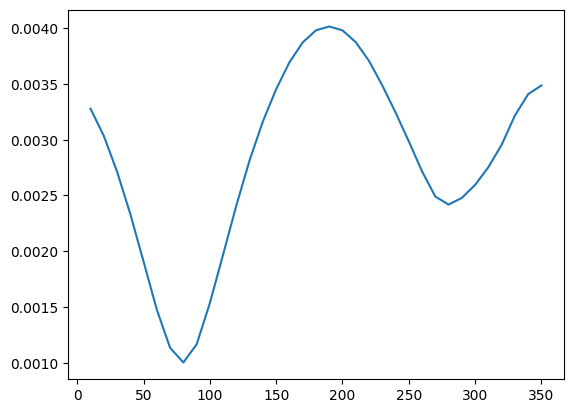

In [93]:
plt.plot(angles, distances)

In [99]:
best_angle = angles[np.argmin(distances)]
best_angle

80

In [111]:
best_rot_matrix = rot_matrices[np.argmin(distances)]
best_rot_matrix

array([[ 0.54978703,  0.27251683,  0.7896004 , -0.0979751 ],
       [ 0.53679555,  0.60898376, -0.58394291,  0.0753086 ],
       [-0.63998809,  0.74489822,  0.18852556,  0.08526237],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [112]:
iimatrix = best_rot_matrix @ imatrix

Combined test

In [113]:
o3d.visualization.draw_geometries([
    # initial alignment
    sfm_data['pcd'], copy.deepcopy(rgbd_data['pcd']).transform(iimatrix),
], window_name=f"{pid} - initial registration")

In [114]:
sfm_pcd_bin = paint_pcd_binary(sfm_data['pcd'], sfm_data['pin_idx'])
rgbd_pcd_bin = paint_pcd_binary(rgbd_data['pcd'], rgbd_data['pin_idx']) 

tmatrix = color_based_icp(rgbd_pcd_bin, sfm_pcd_bin, iimatrix, threshold=0.002)

In [115]:
rgbd_temp, sfm_temp = draw_registration_result(rgbd_data['pcd'], sfm_data['pcd'], tmatrix, paint_color=False, offset=[0.1,0,0], show=True)

TypeError: cannot unpack non-iterable NoneType object

Seems succeed on R3-8!